# San Francisco Crime prediction 
# Based on 2 layer neural net and count featurizer

In [63]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
%matplotlib inline  

Import data

In [64]:
trainDF=pd.read_csv("data/train.csv")
trainDF = trainDF.sample(150000)

Clean up wrong X and Y values (very few of them)

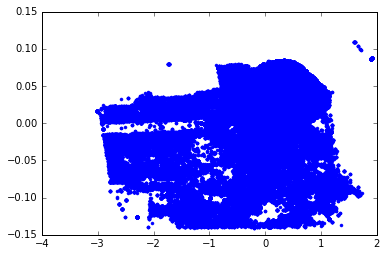

In [65]:
xy_scaler=preprocessing.StandardScaler()
xy_scaler.fit(trainDF[["X","Y"]])
trainDF[["X","Y"]]=xy_scaler.transform(trainDF[["X","Y"]])
trainDF=trainDF[abs(trainDF["Y"])<100]
trainDF.index=range(len(trainDF))
plt.plot(trainDF["X"],trainDF["Y"],'.')
plt.show()

In [66]:
# Split train data into train and dev 80:20, and separate into X,Y
# train_data = df
# shuffle the data:
trainDF = trainDF.reindex(np.random.permutation(trainDF.index))

# take 80% from the top:
upper = np.floor(len(trainDF)*.8).astype(int)
train_data = trainDF.head(n=upper)
train_labels = train_data['Category']

# take 20% from the bottom
lower = np.ceil(len(trainDF)*.2).astype(int)
dev_data = trainDF.tail(n=lower)
dev_labels = dev_data['Category']

Make plots for each crime label

# Now proceed as before

In [67]:
def parse_time(x):
    DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    return time,day,month,year

def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

In [68]:
class ScalerTransform(TransformerMixin):
    
    def __init__(self,cols=[],include=True):
        self.cols = cols
        self.include = include

    def transform(self, X,y=None, **transform_params):
        print("Scaler")
        if self.include:
            x_num_train = X[self.cols]
        else:
            x_num_train = X.drop( self.cols, axis = 1 )
        return self.scaler.transform(x_num_train)
      
    def fit(self, X, y=None, **fit_params):
        if self.include:
            x_num_train = X[self.cols]
        else:
            x_num_train = X.drop( self.cols, axis = 1 )      
        self.scaler = preprocessing.StandardScaler().fit(x_num_train)
        return self


class DatesTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        if('Dates' in X):
            print("Dates")

            DD =X['Dates'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
            time,day,month,year  =  DD.dt.hour, DD.dt.day,DD.dt.month,DD.dt.year  
            return np.array([time,day,month,year]).T
        return 
        

    def fit(self, X, y=None, **fit_params):
        return self

class SeasonsTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        print("Seasons")

        def get_season(x):
            summer=0
            fall=0
            winter=0
            spring=0
            if (x in [5, 6, 7]):
                summer=1
            if (x in [8, 9, 10]):
                fall=1
            if (x in [11, 0, 1]):
                winter=1
            if (x in [2, 3, 4]):
                spring=1
            return summer, fall, winter, spring
        
        if('Dates' in X):
            DD =X['Dates'].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
            awake=DD.dt.hour.apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
            summer, fall, winter, spring=zip(*DD.dt.month.apply(get_season))
            return  np.array([awake,summer,fall,winter,spring]).T        

    def fit(self, X, y=None, **fit_params):
        return self
    
class AddIsIntersectionTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        print("Intersection")

        if('Address' in X):
            return (X["Address"].apply(lambda x: 1 if "/" in x else 0))[:,None]

    def fit(self, X, y=None, **fit_params):
        return self    
    
class StreetNamesTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        def getstreet(x):
            if  "/" in x: 
                return re.findall(r'([A-Z0-9 ]+)\s/\s([A-Z0-9 ]+)', x)
            else: 
                street = re.findall(r'\d+.*?\s+Block of ([A-Z0-9 ]+)', x)
                return [street, street]
        
        print("StreetNames")
        X2 = X.copy()
        streets = X["Address"].apply(getstreet)
        X2['street1'] = streets[0]
        X2['street2'] = streets[1]

        return X2

    def fit(self, X, y=None, **fit_params):
        return self    
    
class LogOddsTransformer(TransformerMixin):
    def __init__(self,togroup):
        self.togroup = togroup

        
    def transform(self, X, **transform_params):
        print "LogOdds transform"
        col = X[','.join(self.togroup)] 
        address_features=col.apply(lambda x: self.logodds[x])
        PA = col.apply(lambda x: self.logoddsPA[x])
        return np.hstack((address_features,PA[:,np.newaxis]))


    def fit(self, X, y=None, **fit_params):
        print("LogOdds")
        categories=sorted(X["Category"].unique())
        X2 = X.assign(Category=y.astype('object'))
        C_counts=X2.groupby(["Category"]).size()
        A_C_counts=X2.groupby(self.togroup +["Category"]).size()
        A_counts=X2.groupby(self.togroup).size()
        addresses=A_counts.keys()
        logodds={}
        logoddsPA={}
        MIN_CAT_COUNTS=2
        default_logodds=np.log(C_counts/len(X2))-np.log(1.0-C_counts/float(len(X2)))
        for addr in addresses:
            PA=A_counts[addr]/float(len(X2))
            logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
            logodds[addr]=deepcopy(default_logodds)
            for cat in A_C_counts[addr].keys():
                if (A_C_counts[addr][cat]>MIN_CAT_COUNTS) and A_C_counts[addr][cat]<A_counts[addr]:
                    PA=A_C_counts[addr][cat]/float(A_counts[addr])
                    logodds[addr][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)
            logodds[addr]=pd.Series(logodds[addr])
            logodds[addr].index=range(len(categories))
        self.logodds=logodds
        self.logoddsPA=logoddsPA
        return self       
    
class MarkDuplicatesTransformer(TransformerMixin):
    def __init__(self,cols,include=True):
        self.cols = cols
        self.include = include

    def transform(self, X, **transform_params):  
        print("Duplicates")
        if self.include:
            X2 = X[self.cols]
        else:
            X2 = X.drop( self.cols, axis = 1 ,errors='ignore')
        return (pd.Series(X2.duplicated()|X2.duplicated(keep="last")).apply(int))[:,None]

    def fit(self, X, y=None, **fit_params):
        return self        



    
class FeatureVecotrizer(TransformerMixin):
    def __init__(self,cols,include=True):
        self.cols = cols
        self.include = include

    def transform(self, X,y=None, **transform_params):
        print("Vectorizer")
        if self.include:
            x_cat_train = X[self.cols]
            x_num_train = X.drop( self.cols, axis = 1 )
        else:
            x_num_train = X[self.cols]
            x_cat_train = X.drop( self.cols, axis = 1 )
        
        x_cat_train.fillna( 'NA', inplace = True )
        vec_x_cat_train  =pd.get_dummies(x_cat_train)
        return vec_x_cat_train

    def fit(self, X,y=None, **fit_params):
        x_cat_train = X[self.cols]
        x_cat_train.fillna( 'NA', inplace = True )
        x_cat_train = x_cat_train.T.to_dict().values()
        return  self
    


In [69]:
class PapaDocNeuralNetworkModel(Sequential):
    
    def __init__(self,hn=32,dp=0.5,layers=1,epochs=1,batches=64,verbose=0,*args,**kwargs):
        self.hn = hn
        self.dp = dp
        self.Nlayers = layers
        self.epochs=epochs
        self.batches = batches
        self.verbose = verbose
        super(PapaDocNeuralNetworkModel,self).__init__(*args,**kwargs)
    
    def fit(self,X_train,y_train,X_test=None,y_test=None,*args,**kwargs):
        y_train=y_train.astype('category')
        input_dim=X_train.shape[1]
        output_dim=len(y_train.unique())
        Y_train=np_utils.to_categorical(y_train.cat.rename_categories(range(len(y_train.unique()))))
        self.add(Dense(input_dim=input_dim, output_dim=self.hn, init='glorot_uniform'))
        self.add(PReLU(input_shape=(self.hn,)))
        self.add(Dropout(self.dp))
        for i in range(self.Nlayers):
            self.add(Dense(input_dim=self.hn, output_dim=self.hn, init='glorot_uniform'))
            self.add(PReLU(input_shape=(self.hn,)))
            self.add(BatchNormalization())
            self.add(Dropout(self.dp))

        self.add(Dense(input_dim=self.hn, output_dim=output_dim, init='glorot_uniform'))
        self.add(Activation('softmax'))
        self.compile(loss='categorical_crossentropy', optimizer='adam')
        if X_test is not None:
            X_test=X_test.as_matrix()
            y_test=y_test.astype('category')
            Y_test=np_utils.to_categorical(y_test.cat.rename_categories(range(len(y_test.unique()))))
            super(PapaDocNeuralNetworkModel,self).fit(X_train, Y_train, nb_epoch=self.epochs, \
                            batch_size=self.batches,verbose=self.verbose,\
                              validation_data=(X_test,Y_test),*args,**kwargs)
        else:
            super(PapaDocNeuralNetworkModel,self).fit(X_train, Y_train, nb_epoch=self.epochs, \
                                                      batch_size=self.batches,verbose=self.verbose,*args,**kwargs)
        return self


In [70]:
N_EPOCHS=20
N_HN=128
N_LAYERS=1
DP=0.5

In [ ]:
#Kyles LR Model

f = FeatureUnion([
                    ("XY",ScalerTransform(["X","Y"])), \
                    ("Vectorizer",FeatureVecotrizer(['PdDistrict','DayOfWeek'])),\
                    ],n_jobs=3)
p = Pipeline(steps=[("FeatureEngineering",f),\
                    ("Model",LogisticRegression(C=.01))
])

#Papadocs Neural Model
f = FeatureUnion([
                    ("XY",ScalerTransform(["X","Y"])), \
                    ("DateToTime",DatesTransformer()), \
                    ("Intersection",AddIsIntersectionTransformer()),\
                    ("Vectorizer",FeatureVecotrizer(['PdDistrict','DayOfWeek'])),\
                    #("LogsOdds",Pipeline([\
                               # ("Street",StreetNamesTransformer()),\
                                #("LogOdds",LogOddsTransformer(["PdDistrict","street1"]))\
                    #])),\
                    ("LogOdds",LogOddsTransformer(["Address"])),\

                    ("MarkDuplicates",MarkDuplicatesTransformer(["PdDistrict","DayOfWeek","Dates","Address"])),\
                    ("Seasons",SeasonsTransformer())
                    ],n_jobs=3)
p = Pipeline(steps=[("FeatureEngineering",f),\
                    ("ScaleEverything",preprocessing.StandardScaler()),\
                    ("Model",PapaDocNeuralNetworkModel(hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP))
])


model = p.fit(train_data,train_labels.astype('category'))

Scaler
Dates
Intersection


/opt/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2756: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


LogOdds
['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']
Duplicates
Seasons


In [ ]:
print "train", log_loss(train_labels.astype('category'), model.predict_proba(train_data))
print "test", log_loss(dev_labels.astype('category'), model.predict_proba(dev_test))

In [ ]:
#Begin Papadocs Code

In [ ]:
def parse_data(df,logodds,logoddsPA):
    feature_list=df.columns.tolist()
    if "Descript" in feature_list:
        feature_list.remove("Descript")
    if "Resolution" in feature_list:
        feature_list.remove("Resolution")
    if "Category" in feature_list:
        feature_list.remove("Category")
    if "Id" in feature_list:
        feature_list.remove("Id")
    cleanData=df[feature_list]
    cleanData.index=range(len(df))
    print "Creating address features"
    address_features=cleanData["Address"].apply(lambda x: logodds[x])

    
    address_features.columns=["logodds"+str(x) for x in range(len(address_features.columns))]
    address_features["logoddsPA"]=cleanData["Address"].apply(lambda x: logoddsPA[x])

    print "Parsing dates"
    cleanData["Time"], cleanData["Day"], cleanData["Month"], cleanData["Year"]=zip(*cleanData["Dates"].apply(parse_time))
#     dummy_ranks_DAY = pd.get_dummies(cleanData['DayOfWeek'], prefix='DAY')
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#     cleanData["DayOfWeek"]=cleanData["DayOfWeek"].apply(lambda x: days.index(x)/float(len(days)))
    print "Creating one-hot variables"
    dummy_ranks_PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
    dummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix='DAY')
    cleanData["IsInterection"]=cleanData["Address"].apply(lambda x: 1 if "/" in x else 0)
    cleanData["logoddsPA"]=cleanData["Address"].apply(lambda x: logoddsPA[x])
    
    print "droping processed columns"
    cleanData=cleanData.drop("PdDistrict",axis=1)
    cleanData=cleanData.drop("DayOfWeek",axis=1)
    cleanData=cleanData.drop("Address",axis=1)
    cleanData=cleanData.drop("Dates",axis=1)
    feature_list=cleanData.columns.tolist()
    print "joining one-hot features"
    features = cleanData[feature_list].join(dummy_ranks_PD.ix[:,:]).join(dummy_ranks_DAY.ix[:,:]).join(address_features.ix[:,:])
    print "creating new features"
    features["IsDup"]=pd.Series(features.duplicated()|features.duplicated(keep="last")).apply(int)
    features["Awake"]=features["Time"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
    features["Summer"], features["Fall"], features["Winter"], features["Spring"]=zip(*features["Month"].apply(get_season))
    if "Category" in df.columns:
        labels = df["Category"].astype('category')
#         label_names=labels.unique()
#         labels=labels.cat.rename_categories(range(len(label_names)))
    else:
        labels=None
    return features,labels

This part is slower than it needs to be.

In [ ]:
addresses=sorted(trainDF["Address"].unique())
categories=sorted(trainDF["Category"].unique())
C_counts=trainDF.groupby(["Category"]).size()
A_C_counts=trainDF.groupby(["Address","Category"]).size()
A_counts=trainDF.groupby(["Address"]).size()
logodds={}
logoddsPA={}
MIN_CAT_COUNTS=2
default_logodds=np.log(C_counts/len(trainDF))-np.log(1.0-C_counts/float(len(trainDF)))
for addr in addresses:
    PA=A_counts[addr]/float(len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
    logodds[addr]=deepcopy(default_logodds)
    for cat in A_C_counts[addr].keys():
        if (A_C_counts[addr][cat]>MIN_CAT_COUNTS) and A_C_counts[addr][cat]<A_counts[addr]:
            PA=A_C_counts[addr][cat]/float(A_counts[addr])
            logodds[addr][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)
    logodds[addr]=pd.Series(logodds[addr])
    logodds[addr].index=range(len(categories))

In [ ]:

features, labels=parse_data(trainDF,logodds,logoddsPA)

In [ ]:
print features.columns.tolist()
print features.shape

In [ ]:
num_feature_list=["Time","Day","Month","Year","DayOfWeek"]
collist=features.columns.tolist()
scaler = preprocessing.StandardScaler()
scaler.fit(features)
features[collist]=scaler.transform(features)


In [ ]:
#new_PCA=PCA(n_components=60)
#new_PCA.fit(features)
#plt.plot(new_PCA.explained_variance_ratio_)
#plt.yscale('log')
#plt.title("PCA explained ratio of features")
#print new_PCA.explained_variance_ratio_

In [ ]:
#plt.plot(new_PCA.explained_variance_ratio_.cumsum())
#plt.title("cumsum of PCA explained ratio")

PCA is interesting, here to play with it more

In [ ]:
sss = StratifiedShuffleSplit(labels, train_size=0.5,random_state=0)
for train_index, test_index in sss:
    features_train,features_test=features.iloc[train_index],features.iloc[test_index]
    labels_train,labels_test=labels[train_index],labels[test_index]
    

features_test.index=range(len(features_test))
features_train.index=range(len(features_train))
labels_train.index=range(len(labels_train))
labels_test.index=range(len(labels_test))
features.index=range(len(features))
labels.index=range(len(labels))
    


In [ ]:
def build_and_fit_model(X_train,y_train,X_test=None,y_test=None,hn=32,dp=0.5,layers=1,epochs=1,batches=64,verbose=0):
    input_dim=X_train.shape[1]
    output_dim=len(labels_train.unique())
    Y_train=np_utils.to_categorical(y_train.cat.rename_categories(range(len(y_train.unique()))))
    model = Sequential()
    model.add(Dense(input_dim=input_dim, output_dim=hn, init='glorot_uniform'))
    model.add(PReLU(input_shape=(hn,)))
    model.add(Dropout(dp))

    for i in range(layers):
        model.add(Dense(input_dim=hn, output_dim=hn, init='glorot_uniform'))
        model.add(PReLU(input_shape=(hn,)))
        model.add(BatchNormalization())
        model.add(Dropout(dp))

    model.add(Dense(input_dim=hn, output_dim=output_dim, init='glorot_uniform'))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    if X_test is not None:
        Y_test=np_utils.to_categorical(y_test.cat.rename_categories(range(len(y_test.unique()))))
        fitting=model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose,validation_data=(X_test,Y_test))
        test_score = log_loss(y_test, model.predict_proba(X_test,verbose=0))
    else:
        model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose)
        fitting=0
        test_score = 0
    return test_score, fitting, model

In [ ]:
len(features.columns)

In [ ]:
#score, fitting, model = build_and_fit_model(features_train.as_matrix(),labels_train,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)


In [ ]:
#print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
#print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
#print "test", log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))

Now train the final model

In [ ]:
score, fitting, model = build_and_fit_model(features.as_matrix(),labels,hn=N_HN,layers=N_LAYERS,
                                            epochs=N_EPOCHS,verbose=2,dp=DP)

In [ ]:
print "all", log_loss(labels, model.predict_proba(features.as_matrix(),verbose=0))
print "train", log_loss(labels_train, model.predict_proba(features_train.as_matrix(),verbose=0))
print "test", log_loss(labels_test, model.predict_proba(features_test.as_matrix(),verbose=0))

In [ ]:
testDF=pd.read_csv("data/test.csv")
testDF[["X","Y"]]=xy_scaler.transform(testDF[["X","Y"]])
#set outliers to 0
testDF["X"]=testDF["X"].apply(lambda x: 0 if abs(x)>5 else x)
testDF["Y"]=testDF["Y"].apply(lambda y: 0 if abs(y)>5 else y)

In [ ]:
new_addresses=sorted(testDF["Address"].unique())
new_A_counts=testDF.groupby("Address").size()
only_new=set(new_addresses+addresses)-set(addresses)
only_old=set(new_addresses+addresses)-set(new_addresses)
in_both=set(new_addresses).intersection(addresses)
for addr in only_new:
    PA=new_A_counts[addr]/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
    logodds[addr]=deepcopy(default_logodds)
    logodds[addr].index=range(len(categories))
for addr in in_both:
    PA=(A_counts[addr]+new_A_counts[addr])/float(len(testDF)+len(trainDF))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)

In [ ]:
features_sub, _=parse_data(testDF,logodds,logoddsPA)
# scaler.fit(features_test)

In [ ]:
collist=features_sub.columns.tolist()

In [ ]:
features_sub[collist]=scaler.transform(features_sub[collist])

In [ ]:
predDF=pd.DataFrame(model.predict_proba(features_sub.as_matrix(),verbose=0),columns=sorted(labels.unique()))

In [ ]:
predDF.head()

In [ ]:
predDF.to_csv("crimeSF_NN_logodds.csv",index_label="Id",na_rep="0")